In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Ignore warnings
import warnings
warnings.simplefilter(action='ignore')

# Install Prerequisites
# import sys
# !{sys.executable} -m pip install scikit-learn scikit-surprise
# !pip install git+https://github.com/gbolmier/funk-svd
# pip install cufflinks


# Exploratory Data Analysis
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Data Preprocessing
import random
from time import time
import cufflinks as cf
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn.preprocessing import StandardScaler
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Models
from surprise import Reader, Dataset
from surprise import SVD, NormalPredictor, BaselineOnly, NMF, SlopeOne, CoClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Performance Evaluation
from surprise import accuracy
from sklearn.metrics import mean_squared_error
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split

# Display
%matplotlib inline
sns.set(font_scale=1)
sns.set_style("white")
pd.set_option('display.max_columns', 37)

In [2]:
train_df = pd.read_csv('./movie_recommendation_data/train.csv')
test_df = pd.read_csv('./movie_recommendation_data/test.csv')
print(train_df.shape, test_df.shape)
train_df.head(3)

(10000038, 4) (5000019, 2)


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539


In [3]:
movies_df =  pd.read_csv('./movie_recommendation_data/movies.csv', index_col='movieId')
imdb_df =  pd.read_csv('./movie_recommendation_data/imdb_data.csv', index_col='movieId')
links_df =  pd.read_csv('./movie_recommendation_data/links.csv', index_col='movieId')
genome_scores =  pd.read_csv('./movie_recommendation_data/genome_scores.csv', index_col='movieId')
genome_tags =  pd.read_csv('./movie_recommendation_data/genome_tags.csv', index_col='tagId')
#tags =  pd.read_csv('/kaggle/input/edsa-movie-recommendation-2022/tags.csv')
print(movies_df.shape, imdb_df.shape, links_df.shape, genome_scores.shape, genome_tags.shape)

(62423, 2) (27278, 5) (62423, 2) (15584448, 2) (1128, 1)


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


In [6]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62423 entries, 1 to 209171
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   62423 non-null  object
 1   genres  62423 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [7]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27278 entries, 1 to 131262
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title_cast     17210 non-null  object 
 1   director       17404 non-null  object 
 2   runtime        15189 non-null  float64
 3   budget         7906 non-null   object 
 4   plot_keywords  16200 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.2+ MB


In [8]:
links_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62423 entries, 1 to 209171
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   imdbId  62423 non-null  int64  
 1   tmdbId  62316 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.4 MB


In [10]:
genome_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15584448 entries, 1 to 206499
Data columns (total 2 columns):
 #   Column     Dtype  
---  ------     -----  
 0   tagId      int64  
 1   relevance  float64
dtypes: float64(1), int64(1)
memory usage: 356.7 MB


In [9]:
genome_tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128 entries, 1 to 1128
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tag     1128 non-null   object
dtypes: object(1)
memory usage: 17.6+ KB


In [11]:
print("Train: ")
print(str(train_df.isnull().sum()))
print("============")
print("Test: ")
print(str(test_df.isnull().sum()))
print("============")
print("Movies: ")
print(str(movies_df.isnull().sum()))
# print("============")
# print("Tags: ")
# print(str(tags_df.isnull().sum()))
print("============")
print("Links: ")
print(str(links_df.isnull().sum()))
print("============")
print("IMDB: ")
print(str(imdb_df.isnull().sum()))
print("============")
print("Genome scores: ")
print(str(genome_scores.isnull().sum()))
print("============")
print("Genome tags: ")
print(str(genome_tags.isnull().sum()))

Train: 
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Test: 
userId     0
movieId    0
dtype: int64
Movies: 
title     0
genres    0
dtype: int64
Links: 
imdbId      0
tmdbId    107
dtype: int64
IMDB: 
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64
Genome scores: 
tagId        0
relevance    0
dtype: int64
Genome tags: 
tag    0
dtype: int64


In [12]:
# Drop missing rows
# tags_df.dropna(axis=0,inplace=True)
links_df.dropna(axis=0,inplace=True)

In [60]:
# Drop duplicate movie titles?
#movies_df.drop_duplicates(subset="title", keep=False, inplace=True)

In [13]:
def user_ratings_count(df, n):
    """
    Counts the number of user ratings.
    Parameters
    ----------
        df (DataFrame): input DataFrame
        n (int): number of users to show
    Returns
    -------
        barplot (NoneType): barplot of top n users by number of observations
    Example
    -------
        >>> df = pd.DataFrame({'userId':[1,2,3,1,2,4,5,4]})
        >>> user_ratings_count(df, 3)
            NoneType (barplot)
    """
    plt.figure(figsize=(8,6))
    data = df['userId'].value_counts().head(n)
    ax = sns.barplot(x = data.index, y = data, order= data.index, palette='brg', edgecolor="black")
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=11, ha='center', va='bottom')
    plt.title(f'Top {n} Users by Number of Ratings', fontsize=14)
    plt.xlabel('User ID')
    plt.ylabel('Number of Ratings')
    print("Combined number of ratings:\t",df['userId'].value_counts().head(n).sum(),
         "\nTotal number of movies:\t\t", df['movieId'].nunique())
    plt.show()

Combined number of ratings:	 34398 
Total number of movies:		 48213


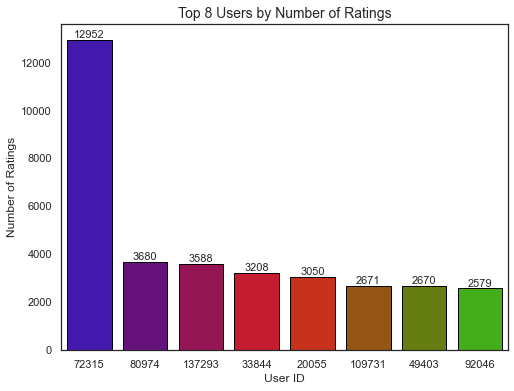

In [14]:
user_ratings_count(train_df,8)

In [17]:
# Exclude user 72315 for EDA
eda_df = train_df[train_df['userId']!=72315]

Combined number of ratings:	 23734 
Total number of movies:		 45844


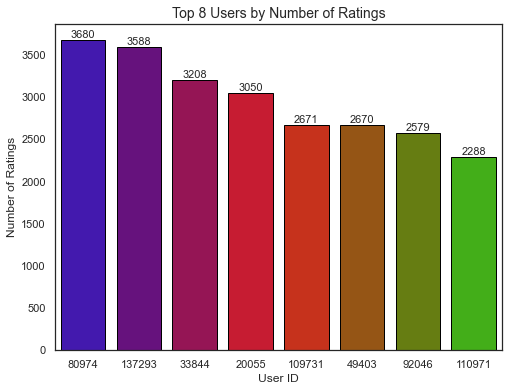

In [18]:
user_ratings_count(eda_df,8)

In [65]:
# How many ratings have we lost?
34398-23734

In [66]:
# How many movies were only rated by our outlier?
48213-45844

In [19]:
def ratings_distplot(df, column='rating'):
    """
    Plots the distribution of ratings in the dataset.
    Parameters
    ----------
        df (DataFrame): input DataFrame
        column (str): column to plot
    Returns
    -------
        distplot (NoneType): distplot of rating frequencies
    """
    plt.figure(figsize=(8,6))
    ax = sns.distplot(df[f'{column}'],bins=10, kde=False, hist_kws=dict(alpha=0.6),color="#4D17A0")
    mean = df[f'{column}'].mean()
    median = df[f'{column}'].median()
    plt.axvline(x=mean, label = f'mean {round(mean,2)}' , color='#4D17A0', lw=3, ls = '--')
    plt.axvline(x=median, label = f'median {median}' , color='#4DA017', lw=3, ls = '--')
    plt.xlim((0.5,5))
    plt.ylim((0,2500000))
    plt.title(f'Distribution of Ratings', fontsize=14)
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

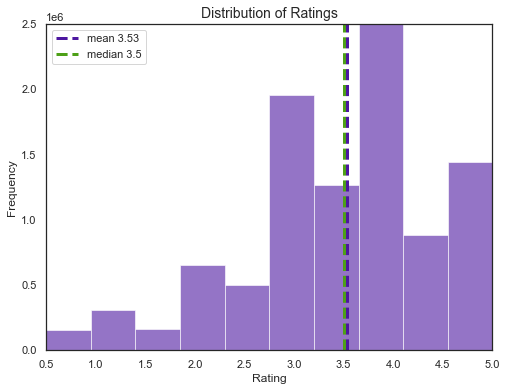

In [20]:
ratings_distplot(eda_df)

In [21]:
def mean_ratings_scatter(df, color='#4DA017', column='userId'):
    """
    Make scatterplots of mean ratings.
    Parameters
    ----------
        df (DataFrame): input DataFrame
        color (str): plot colour
        column (str): column to plot
    Returns
    -------
        scatterplot (NoneType): scatterplot of mean number of ratings
    """
    plt.figure(figsize=(6,4))
    mean_ratings = df.groupby(f'{column}')['rating'].mean()
    user_counts = df.groupby(f'{column}')['movieId'].count().values
    sns.scatterplot(x=mean_ratings, y = user_counts, color=color)
    plt.title(f'Mean Ratings by Number of Ratings', fontsize=14)
    plt.xlabel('Rating')
    plt.ylabel('Number of Ratings')
    plt.show()

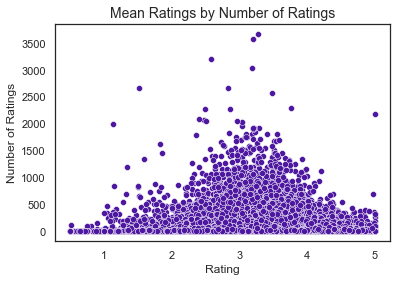

In [22]:
# Mean user ratings by number of ratings
mean_ratings_scatter(eda_df,'#4D17A0')

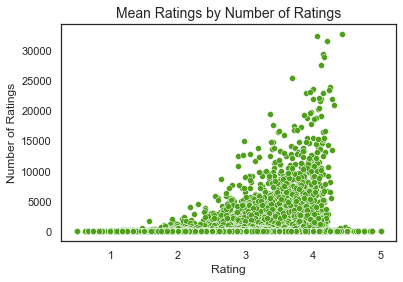

In [23]:
# Mean movie ratings by number of ratings
mean_ratings_scatter(eda_df, column='movieId')

In [24]:
# movie eda
ratings = train_df.merge(movies_df, on='movieId', how='inner') # Merge train with movies to join movie titles and ratings 
ratings.drop('timestamp', axis=1, inplace=True)  #drop timestamp after joining the train with movies dataset
ratings.head()

,userId,movieId,rating,title,genres
0,5163,57669,4.0,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,In Bruges (2008),Comedy|Crime|Drama|Thriller
2,137050,57669,4.0,In Bruges (2008),Comedy|Crime|Drama|Thriller
3,120490,57669,4.5,In Bruges (2008),Comedy|Crime|Drama|Thriller
4,50616,57669,4.5,In Bruges (2008),Comedy|Crime|Drama|Thriller


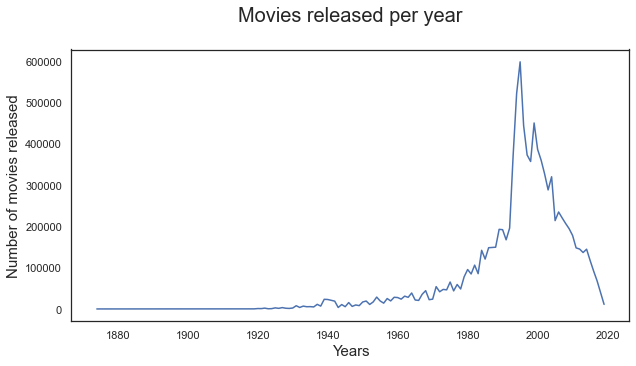

In [25]:
# Extract the release year fron the movie titles
ratings['release_year'] = ratings.title.map(lambda x: re.findall('\d\d\d\d', x))
ratings.release_year = ratings.release_year.apply(lambda x: np.nan if not x else int(x[-1]))
years =  pd.DataFrame(ratings.groupby(['release_year'])['title'].count())
years.rename(columns={'title':'movies released'}, inplace=True)

# Plot the number of movies released per year
plt.figure(figsize=(10,5))
plot = sns.lineplot(data=years, dashes=False, legend=False, color='#2F4F4F')

# Add figure labels
plt.xlabel('Years', fontsize=15)
plt.ylabel('Number of movies released', fontsize=15)
plt.title('Movies released per year\n', fontsize=20)

plt.show() 

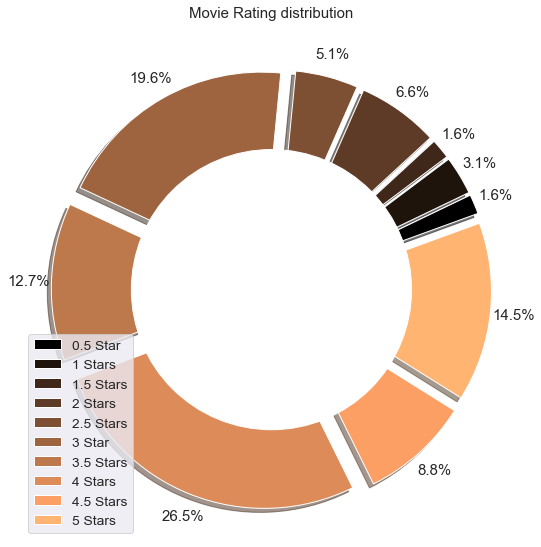

In [26]:
# Merge train with movies to join movie titles and ratings 
ratings = train_df.merge(movies_df, on='movieId', how='inner')
ratings.drop('timestamp', axis=1, inplace=True)

# Count how many ratings are in each category (1 star, 2 star, ect)
grouped = pd.DataFrame(ratings.groupby(['rating'])['title'].count())
grouped.rename(columns={'title':'rating_count'}, inplace=True)

# Creating plots 
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(122)
    
# Create colour palette
labels = ['0.5 Star', '1 Stars', '1.5 Stars', '2 Stars', '2.5 Stars', '3 Star', '3.5 Stars', '4 Stars', '4.5 Stars', '5 Stars']
theme = plt.get_cmap('copper')
ax.set_prop_cycle("color", [theme(1. * i / len(labels))
                                 for i in range(len(labels))])
sns.set(font_scale=1.25)

# Create pie chart
pie = ax.pie(grouped['rating_count'],
                 autopct='%1.1f%%',
                 shadow=True,
                 startangle=20,
                 pctdistance=1.115,
                 explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1))
   
# Turn pie chart into a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Display donut plot with legend
plt.legend(pie[0], labels, loc="lower left")
ax.set_title('Movie Rating distribution\n', fontsize=15)
plt.tight_layout()
plt.show()

In [72]:
def plot_ratings(count, n, color='#4DA017', best=True, method='mean'):
    """
    Make scatterplots of ratings.
    Parameters
    ----------
        count (int): number of ratings threshold
        n (int): number of movies
        color (str): plot colour
        best (bool): column to plot
        method (str): statistical measure
    Returns
    -------
        scatterplot (NoneType): scatterplot of mean number of ratings
    """
    # What are the best and worst movies
    # Creating a new DF with mean and count
    if method == 'mean':
        movie_avg_ratings = pd.DataFrame(eda_df.join(movies_df, on='movieId', how='left').groupby(['movieId', 'title'])['rating'].mean())
    else:
        movie_avg_ratings = pd.DataFrame(eda_df.join(movies_df, on='movieId', how='left').groupby(['movieId', 'title'])['rating'].median())
    movie_avg_ratings['count'] = eda_df.groupby('movieId')['userId'].count().values
    movie_avg_ratings.reset_index(inplace=True)
    movie_avg_ratings.set_index('movieId', inplace=True)

    # Remove movies that have been rated fewer than n times
    data = movie_avg_ratings[movie_avg_ratings['count']>count]
    data.sort_values('rating', inplace= True,ascending=False)
    if best == True:
        plot = data.head(n).sort_values('rating', ascending=True)
        title='Best Rated'
    else:
        plot = data.tail(n).sort_values('rating', ascending=False)
        title='Worst Rated'
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=plot['rating'], y=plot['title'], size=plot['count'], color=color)
    plt.xlabel('Rating')
    plt.ylabel('')
    plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
    plt.title(f'Top {n} {title} Movies with Over {count} Ratings', fontsize=14)
    plt.show()

In [73]:
# What are the top 10 highest rated titles?
plot_ratings(10000, 15, '#4D17A0', True, 'mean')

In [74]:
# What are the 10 worst rated titles?
plot_ratings(500, 15,'#4DA017', False, 'mean')

In [75]:
movieRatingDistGroup = train_df['rating'].value_counts().sort_index().reset_index()
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=movieRatingDistGroup, x='index', y='rating', palette="brg", edgecolor="black", ax=ax)
ax.set_xlabel("Rating")
ax.set_ylabel('Number of Users')
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
total = float(movieRatingDistGroup['rating'].sum())
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height+350, '{0:.2%}'.format(height/total), fontsize=11, ha="center", va='bottom')
plt.title('Number of Users Per Rating', fontsize=14)
plt.show()

In [76]:
# function that hasn't found a use yet - it was usefull in the app!!
def feat_extractor(df, col):
    """
    Returns a list of all unique features in a DataFrame columns separated by "|"
    """
    df.fillna("", inplace=True)
    feat_set = set()
    for i in range(len(df[f'{col}'])):
        for feat in df[f'{col}'].iloc[i].split('|'):
            feat_set.add(feat)
    return sorted([feat for feat in feat_set if feat != ""])

In [77]:
genres = feat_extractor(movies_df, 'genres')

In [78]:
def feature_frequency(df, column):
    """
    Function to count the number of occurences of metadata such as genre
    Parameters
    ----------
        df (DataFrame): input DataFrame containing movie metadata
        column (str): target column to extract features from
    Returns
    -------
        
    """
    # Creat a dict to store values
    df = df.dropna(axis=0)
    genre_dict = {f'{column}': list(),
                 'count': list(),}
    # Retrieve a list of all possible genres
    print('retrieving features...')
    for movie in range(len(df)):
        gens = df[f'{column}'].iloc[movie].split('|')
        for gen in gens:
            if gen not in genre_dict[f'{column}']:
                genre_dict[f'{column}'].append(gen)
    # count the number of occurences of each genre
    print('counting...')
    for genre in genre_dict[f'{column}']:
        count = 0
        for movie in range(len(df)):
            gens = df[f'{column}'].iloc[movie].split('|')
            if genre in gens:
                count += 1
        genre_dict['count'].append(count)
        
        # Calculate metrics
    data = pd.DataFrame(genre_dict)
    print('done!')
    return data
genres = feature_frequency(movies_df, 'genres')

In [79]:
def feature_count(df, column):
    plt.figure(figsize=(10,6))
    ax = sns.barplot(y = df[f'{column}'], x = df['count'], palette='brg', orient='h')
    plt.title(f'Number of Movies Per {column}', fontsize=14)
    plt.ylabel(f'{column}')
    plt.xlabel('Count')
    plt.show()

In [80]:
feature_count(genres.sort_values(by = 'count', ascending=False), 'genres')

In [81]:
def mean_calc(feat_df, ratings = eda_df, movies = movies_df, metadata = imdb_df, column = 'genres'):
    mean_ratings = pd.DataFrame(ratings.join(movies, on='movieId', how='left').groupby(['movieId'])['rating'].mean())
    movie_eda = movies.copy()
    movie_eda = movie_eda.join(mean_ratings, on = 'movieId', how = 'left')

    # Exclude missing values
    movie_eda = movie_eda
    movie_eda2 = movie_eda[movie_eda['rating'].notnull()]

    means = []
    for feat in feat_df[f'{column}']:
        mean = round(movie_eda2[movie_eda2[f'{column}'].str.contains(feat)]['rating'].mean(),2)
        means.append(mean)
    return means

In [82]:
genres['mean_rating'] = mean_calc(genres)

In [83]:
genres.sort_values('mean_rating', ascending=False).head(5)

In [84]:
def genre_popularity(df):
    """
    Plots the mean rating per genre.
    """
    count_filt = 500
    plt.figure(figsize=(10,6))
    plot_data = df[df['count']>count_filt]
    mean = plot_data['mean_rating'].mean()
    min_ = plot_data['mean_rating'].min()
    max_ = plot_data['mean_rating'].max()
    sns.barplot(y = plot_data['genres'], x = plot_data['mean_rating'], order = plot_data['genres'], orient='h',palette='brg')
    plt.axvline(x=mean, label = f'mean {round(mean,1)}' , color='black', lw=1, ls ='--')
    plt.axvline(x=min_, label = f'min {round(min_,1)}' , color='#4D17A0', lw=1, ls = '--')
    plt.axvline(x=max_, label = f'max {max_}' , color='#4DA017', lw=1,ls = '--')
    plt.title(f'Mean Rating Per Genre', fontsize=14)
    plt.ylabel('Genre')
    plt.xlabel('Mean Rating')
    plt.legend(loc='lower center')
    plt.show()

In [85]:
genre_popularity(genres.sort_values('mean_rating', ascending=False))

In [89]:
box = mean_ratings.join(movies_df)
box['genres'] = box['genres'].str.replace('|', ',')
box['genres'] = box['genres'].apply(lambda x: x.split(","))
box = box.explode('genres')
box = box[box['genres']!='(no genres listed)']

fig,axis = plt.subplots(figsize=(10, 8))
sns.boxplot(y=box['genres'], x=box['rating'], palette="brg", orient='h', showfliers = False)
plt.title("Distribution of Ratings Per Genre", fontsize=14)
plt.xlabel("Rating")
plt.ylabel("Genre")
plt.show()

In [90]:
def count_directors(df, count = 10):
    """
    Function to count the most common dircetors in a DataFrame:
    Parameters
    ----------
        df (DataFrame): input dataframe containing imdb metadata
        count (int): filter directors with fewer than count films
        
    Returns
    -------
        directors (DataFrame): output DataFrame
    Examples
    --------
        >>> df = pd.DataFrame({'imdbid':[0,1,2,3,4,5], 'director': [A,B,A,C,B]})
        >>> count_directors(df, count = 1)
            |index|director|count|
            |0|A|2|
            |1|B|2|
            |2|C|1|
    """
    directors = pd.DataFrame(df['director'].value_counts()).reset_index()
    directors.columns = ['director', 'count']
    # Lets only take directors who have made 10 or more movies otherwise we will have to analyze 11000 directors
    directors = directors[directors['count']>=count]
    return directors.sort_values('count', ascending = False)
directors = count_directors(imdb_df)

In [91]:
feature_count(directors.head(10), 'director')

In [92]:
def dir_mean(df):
    df.set_index('director', inplace=True)

    direct_ratings = []
    directors_eda = eda_df.join(imdb_df, on = 'movieId', how = 'left')
    for director in df.index:
        rating = round(directors_eda[directors_eda['director']==director]['rating'].mean(),2)
        direct_ratings.append(rating)
    df['mean_rating'] = direct_ratings
    return df.sort_values('mean_rating', ascending = False)

In [93]:
directors = dir_mean(directors)

In [94]:
directors.head()

In [95]:
def feat_popularity(df, title = 'feat'):
    """
    Plots the mean rating per director.
    """
    plt.figure(figsize=(10,6))
    plot_data = df.copy()
    mean = plot_data['mean_rating'].mean()
    min_ = plot_data['mean_rating'].min()
    max_ = round(plot_data['mean_rating'].max(),2)
    sns.barplot(y = plot_data.index, x = plot_data['mean_rating'], order = plot_data.index, orient='h',palette='brg')
    plt.axvline(x=mean, label = f'mean {round(mean,1)}' , color='black', lw=1, ls ='--')
    plt.axvline(x=min_, label = f'min {round(min_,1)}' , color='#4D17A0', lw=1, ls = '--')
    plt.axvline(x=max_, label = f'max {max_}' , color='#4DA017', lw=1,ls = '--')
    plt.title(f'Mean Rating Per {title}', fontsize=14)
    plt.ylabel(f'{title}')
    plt.xlabel('Mean Rating')
    plt.legend(loc='lower center')
    plt.show()

In [96]:
feat_popularity(directors.head(10), 'Director')

In [97]:
feat_popularity(directors.tail(10), 'Director')

In [98]:
# Subset the data to cut down computation time for now
genome_score = genome_scores[:10000000]

In [99]:
# Although scores are in the range of 0-1, there is no harm in scaling
scaler_mds = StandardScaler()
mds_genome = scaler_mds.fit_transform(genome_score.sample(frac=0.0001))

In [100]:
tsne = TSNE(3, n_jobs = -1, verbose = 2, perplexity = 10, learning_rate = 0.1)

In [101]:
tsne.fit(mds_genome)

In [102]:
Axes3D

fig = plt.figure(figsize=(15, 8))

# Add 3D scatter plot
ax = fig.add_subplot(projection='3d')
ax.scatter(tsne.embedding_[:,0], tsne.embedding_[:,1], tsne.embedding_[:,2], color='#4D17A0')
plt.show()

In [103]:
fig = plt.figure(figsize=(8, 6))
sns.scatterplot(x = tsne.embedding_[:,0], y = tsne.embedding_[:,1], size=tsne.embedding_[:,2],color='#4DA017')
plt.show()

In [104]:
# Manually pivot table as data is too large for in-built functions
def pivot_(df):
    """
    Pivots table.
    """
    new_dict = {'movieId':sorted(set(df.index))}
    pivoted = pd.DataFrame(new_dict)
    tagids = sorted(set(df['tagId']))
    for Id in range(len(tagids)):
        pivoted[f'{Id+1}'] = list(df[df['tagId'] == Id+1]['relevance'])
    return pivoted

In [105]:
pca_data_pivoted = pivot_(genome_scores).set_index('movieId')

In [106]:
pca_data_pivoted.shape

In [107]:
pca_data_pivoted.columns = list(genome_tags['tag'])

In [108]:
pca_data_pivoted.head()

In [109]:
features = [col for col in pca_data_pivoted.columns]

In [111]:
cf.set_config_file(offline=True, world_readable=True, theme='white')
columns = random.sample(range(0, 1129), 20)
pca_data_pivoted.iloc[:,columns].iplot(kind='box', title="Boxplots of Features (Unscaled)")

In [112]:
def scaler(df):
    """
    Scales data.
    """
    scaler = StandardScaler(with_std=True)
    scaled_data = scaler.fit_transform(df)
    return scaled_data

In [113]:
pca_scaled = scaler(pca_data_pivoted)

In [114]:
scaled_pca = pd.DataFrame(pca_scaled, index = pca_data_pivoted.index, columns = pca_data_pivoted.columns)

In [115]:
cf.set_config_file(offline=True, world_readable=True, theme='white')
# using plotly to plot the boxplot
scaled_pca.iloc[:,columns].iplot(kind='box', title="Boxplots of Features (Scaled)")

In [116]:
# define PCA object
pca = PCA()

# fit the PCA model to our data and apply the dimensionality reduction 
prin_comp = pca.fit_transform(pca_data_pivoted[features])

# create a dataframe containing the principal components
pca_df = pd.DataFrame(data = prin_comp,
                      index=pca_data_pivoted.index, columns=pca_data_pivoted.columns
                     )

# plot line graph of cumulative variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_),color='#4D17A0')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [117]:
pca_75 = PCA(.80)
pca_75_df = pca_75.fit_transform(pca_data_pivoted)
print(round(pca_75.explained_variance_ratio_.sum()*100, 1),
      "% of variance explained by",
      pca_75.n_components_,
      "components.")

In [118]:
pca_75_df = pd.DataFrame(pca_75_df, index = pca_data_pivoted.index)
pca_75_df.head()

In [119]:
# Manually implement the WCSS
def within_cluster_variation(df, label_col='cluster_label'):
    """
    Manually implements the WCSS.
    """
    centroids = df.groupby(label_col).mean()
    out = 0
    for label, point in centroids.iterrows():
        df_features = df[df[label_col] == label].drop(label_col, axis=1)
        out += (df_features - point).pow(2).sum(axis=1).sum()
    return out

In [120]:
# let's try everything between 2 and 18 clusters where 18 is the number of genres
n_clusters = np.arange(2, 19)

# store errors for each value of k
errors = []

# for i between 2 and 19
for k in n_clusters:
    print(f'training model with {k} clusters')
    # perform k-means clustering
    km = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    km.fit(pca_75_df)
    
    # measure BCSS
    print(f'evaluating model with {k} clusters')
    y_preds = km.predict(pca_75_df)
    pca_75_df = pd.DataFrame(pca_75_df)
    pca_75_df['cluster_label'] = y_preds
    errors.append(within_cluster_variation(pca_75_df, 'cluster_label'))
    print(errors[-1])

In [121]:
plt.figure(figsize=(12,8))
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Determining Optimal Value of k')
plt.scatter(n_clusters, errors, color="#4DA017")
plt.plot(n_clusters, errors)
plt.xticks(n_clusters)
plt.axvline(x=3, color='#4D17A0', lw=2)
plt.show()

In [122]:
K = 3
# Remember to set the random state for reproducibility
km = KMeans(n_clusters=K, verbose=0, random_state=42)
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(pca_75_df)
print("done in %0.3fs" % (time() - t0))

In [123]:
# Obtain cluster memberships for each item in the data
y_preds = km.predict(pca_75_df)
pca_75_df['cluster_label'] = y_preds
centers = km.cluster_centers_

In [124]:
plt.figure(dpi=120)
for k in range(K):
    x1 = pca_75_df[pca_75_df['cluster_label'] == k][0]
    x2 = pca_75_df[pca_75_df['cluster_label'] == k][1]
    plt.scatter(x1, x2, label="k = "+str(k+1),alpha=0.75)
# Show cluster centroid locations    
plt.scatter(centers[:,0],centers[:,1],label="centroid")
plt.legend()
plt.title(f"K = {K}")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [125]:
# Load the 100k dataset
train_df.drop('timestamp', axis=1, inplace=True)
train_subset = train_df[:100000]
reader = Reader(rating_scale=(train_subset['rating'].min(), train_subset['rating'].max()))
data = Dataset.load_from_df(train_subset[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=42)

In [126]:
svd_test = SVD(n_epochs = 30, n_factors = 200, init_std_dev = 0.05, random_state=42)
svd_test.fit(trainset)
predictions = svd_test.test(testset)
# Calculate RMSE
svd_rmse = accuracy.rmse(predictions)

In [127]:
np_test = NormalPredictor()
np_test.fit(trainset)
predictions = np_test.test(testset)
# Calculate RMSE
np_rmse = accuracy.rmse(predictions)

In [128]:
bsl_options = {'method': 'sgd','n_epochs': 40}
blo_test = BaselineOnly(bsl_options=bsl_options)
blo_test.fit(trainset)
predictions = blo_test.test(testset)
# Calculate RMSE
blo_rmse = accuracy.rmse(predictions)

In [129]:
nmf_test = NMF()
nmf_test.fit(trainset)
predictions = nmf_test.test(testset)
# Calculate RMSE
nmf_rmse = accuracy.rmse(predictions)

In [130]:
slo_test = SlopeOne()
slo_test.fit(trainset)
predictions = slo_test.test(testset)
# Calculate RMSE
slo_rmse = accuracy.rmse(predictions)

In [131]:
cc_test = CoClustering(random_state=42)
cc_test.fit(trainset)
predictions = cc_test.test(testset)
# Calculate RMSE
cc_rmse = accuracy.rmse(predictions)

In [132]:
def data_preprocessing(subset_size):
    """Prepare data for use within Content filtering algorithm.

    Parameters
    ----------
    subset_size : int
        Number of movies to use within the algorithm.

    Returns
    -------
    Pandas Dataframe
        Subset of movies selected for content-based filtering.

    """
    # Split genre data into individual words.
    movies['keyWords'] = movies['genres'].str.replace('|', ' ')
    # Subset of the data
    movies_subset = movies[:subset_size]
    return movies_subset
 
def content_model(movie_list,top_n=10): 
    """Performs Content filtering based upon a list of movies supplied
       by the app user.

    Parameters
    ----------
    movie_list : list (str)
        Favorite movies chosen by the app user.
    top_n : type
        Number of top recommendations to return to the user.

    Returns
    -------
    list (str)
        Titles of the top-n movie recommendations to the user.

    """
    # Initializing the empty list of recommended movies
    data = data_preprocessing(2000)
    # Instantiating and generating the count matrix
    count_vec = CountVectorizer()
    count_matrix = count_vec.fit_transform(data['keyWords'])
    indices = pd.Series(data['title'])
    cosine_sim = cosine_similarity(count_matrix, count_matrix)
    cosine_sim = pd.DataFrame(cosine_sim, index = data.index, columns = data.index)
    # Getting the index of the movie that matches the title
    idx_1 = indices[indices == movie_list[0]].index[0]
    idx_2 = indices[indices == movie_list[1]].index[0]
    idx_3 = indices[indices == movie_list[2]].index[0]
    # Creating a Series with the similarity scores in descending order
    rank_1 = cosine_sim[idx_1]
    rank_2 = cosine_sim[idx_2]
    rank_3 = cosine_sim[idx_3]
    # Calculating the scores
    score_series_1 = pd.Series(rank_1).sort_values(ascending = False)
    score_series_2 = pd.Series(rank_2).sort_values(ascending = False)
    score_series_3 = pd.Series(rank_3).sort_values(ascending = False)
    # Getting the indexes of the 10 most similar movies
    listings = score_series_1.append(score_series_2).append(score_series_3).sort_values(ascending = False)
    # Store movie names
    recommended_movies = []
    # Appending the names of movies
    top_50_indexes = list(listings.iloc[1:50].index)
    # Removing chosen movies
    top_indexes = np.setdiff1d(top_50_indexes,[idx_1,idx_2,idx_3])
    for i in top_indexes[:top_n]:
        recommended_movies.append(list(movies['title'])[i])
    return recommended_movies

In [133]:
movies = movies_df.dropna()
movie_list = ['Grumpier Old Men (1995)','Ace Ventura: When Nature Calls (1995)','Father of the Bride Part II (1995)']
content_model(movie_list,top_n=10)

In [134]:
# Compare RMSE values between models
fig,axis = plt.subplots(figsize=(8, 5))
rmse_x = ['SVD','NormalPredictor','BaselineOnly','NMF','SlopeOne','CoClustering']
rmse_y = [svd_rmse,np_rmse,blo_rmse,nmf_rmse,slo_rmse,cc_rmse]
ax = sns.barplot(x=rmse_x, y=rmse_y,palette='brg',edgecolor='black')
plt.title('RMSE Value Per Collaborative-based Filtering Model',fontsize=14)
plt.xticks(rotation=90)
plt.ylabel('RMSE')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height(), round(p.get_height(),2), fontsize=12, ha="center", va='bottom')
    
plt.show()

In [135]:
svd_test = SVD(n_epochs = 40, n_factors = 200, init_std_dev = 0.05, random_state=42)
# Run 5-fold cross-validation and print results
a = cross_validate(svd_test, data, measures=['RMSE'], cv=5, verbose=True)

In [136]:
bsl_options = {'method': 'sgd','n_epochs': 40}
blo_test = BaselineOnly(bsl_options=bsl_options)
# Run 5-fold cross-validation and print results
b = cross_validate(blo_test, data, measures=['RMSE'], cv=5, verbose=True)

In [137]:
# Load the 100k dataset
train_subset = train_df[:100000]
reader = Reader(rating_scale=(train_subset['rating'].min(), train_subset['rating'].max()))
data = Dataset.load_from_df(train_subset[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=42)

In [138]:
param_grid = {'n_epochs':[40], #[30,40,50],
              'n_factors':[400], #[100,200,300,400],
              'init_std_dev':[0.005], #[0.001,0.005,0.05,0.1],
              'random_state':[42]} 
grid_SVD = GridSearchCV(SVD, cv=5, measures=['rmse'], param_grid=param_grid, n_jobs=-1)
grid_SVD.fit(data)
print('***Best score:***')
print(grid_SVD.best_score['rmse'])
print('***Best parameters:***')
print(grid_SVD.best_params['rmse'])

In [139]:
svd_test = SVD(n_epochs = 40, n_factors = 400, init_std_dev = 0.005, random_state=42)
svd_test.fit(trainset)
predictions = svd_test.test(testset)
# Calculate RMSE
svd_rmse = accuracy.rmse(predictions)

In [140]:
# Predicted Target Values vs. Actual Target Values
new_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in testset:
    new_df.loc[i] = [uid, iid, rating]
    i = i+1
true = new_df['rating']
pred = []
for i in predictions:
    pred.append(i.est)
fig,axis = plt.subplots(figsize=(8, 5))
sns.boxplot(x=true, y=pred, palette="brg")
plt.title("Predicted Target Values vs. Actual Target Values", fontsize=14)
plt.xlabel("Actual Target Values")
plt.ylabel("Predicted Target Values")
plt.show()

In [141]:
# Train model on whole dataset
reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))
data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()
svd = SVD(n_epochs = 40, n_factors = 400, init_std_dev = 0.005, random_state=42, verbose=True)
svd.fit(trainset)

# Create Kaggle submission file
predictions = []
for i, row in test_df.iterrows():
    x = (svd.predict(row.userId, row.movieId))
    pred = x[3]
    predictions.append(pred)
test_df['Id'] = test_df['userId'].map(str) +'_'+ test_df['movieId'].map(str)
results = pd.DataFrame({"Id":test_df['Id'],"rating": predictions})
results.to_csv("NM2_1st_submission.csv", index=False)